<a href="https://colab.research.google.com/github/fabianorc2506-sys/Fundamentos-em-Ci-ncias-de-Dados/blob/main/Trabalho_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Melhor valor de k encontrado: 11


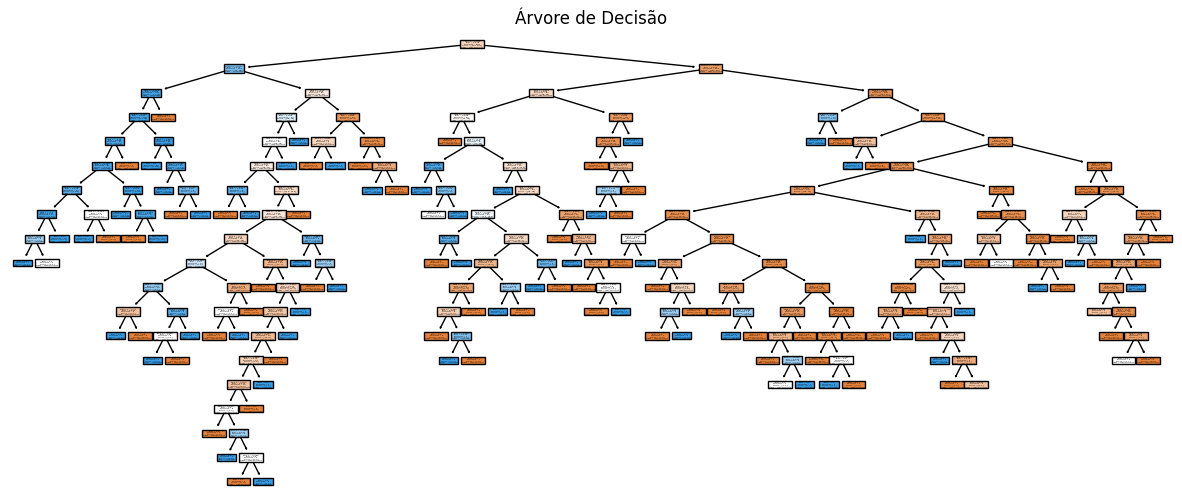


=== Métricas para KNN ===
Matriz de Confusão:
[[68 12]
 [18 45]]
TP: 45, TN: 68, FP: 12, FN: 18
Acurácia: 0.7902
Precisão: 0.7895
Recall (Sensibilidade): 0.7143
Especificidade: 0.8500
F1 Score: 0.7500
Valor Preditivo Negativo: 0.7907
ROC-AUC: 0.8512


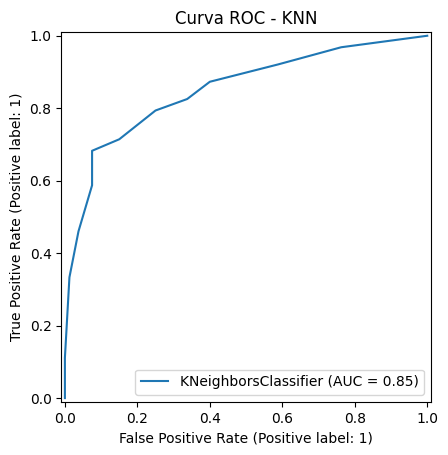


=== Métricas para SVM ===
Matriz de Confusão:
[[73  7]
 [17 46]]
TP: 46, TN: 73, FP: 7, FN: 17
Acurácia: 0.8322
Precisão: 0.8679
Recall (Sensibilidade): 0.7302
Especificidade: 0.9125
F1 Score: 0.7931
Valor Preditivo Negativo: 0.8111
ROC-AUC: 0.8581


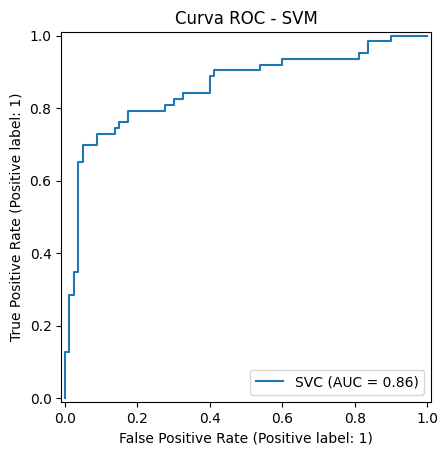


=== Métricas para Decision Tree ===
Matriz de Confusão:
[[63 17]
 [24 39]]
TP: 39, TN: 63, FP: 17, FN: 24
Acurácia: 0.7133
Precisão: 0.6964
Recall (Sensibilidade): 0.6190
Especificidade: 0.7875
F1 Score: 0.6555
Valor Preditivo Negativo: 0.7241
ROC-AUC: 0.7136


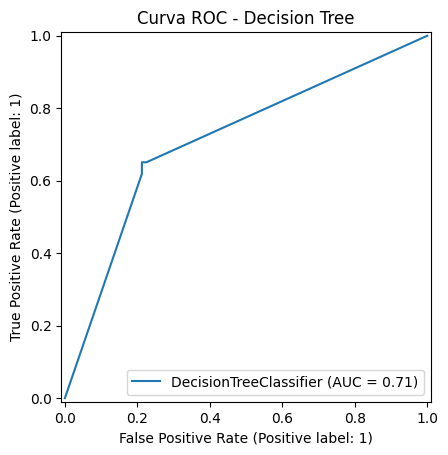


=== Métricas para Logistic Regression ===
Matriz de Confusão:
[[70 10]
 [22 41]]
TP: 41, TN: 70, FP: 10, FN: 22
Acurácia: 0.7762
Precisão: 0.8039
Recall (Sensibilidade): 0.6508
Especificidade: 0.8750
F1 Score: 0.7193
Valor Preditivo Negativo: 0.7609
ROC-AUC: 0.8230


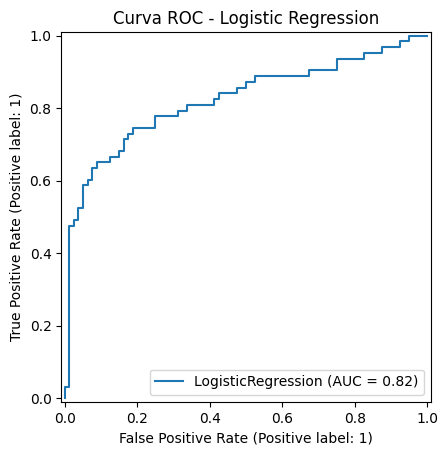

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, classification_report,
    RocCurveDisplay
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression

# 1. Carregamento e seleção de variáveis
titanic = sns.load_dataset('titanic')
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'alone']
target = 'survived'
df = titanic[features + [target]].copy()

# 2. Tratamento de valores ausentes
df.dropna(inplace=True)

# 3. Codificação de variáveis categóricas
label_enc = LabelEncoder()
for col in ['sex', 'embarked', 'alone']:
    df[col] = label_enc.fit_transform(df[col])

# 4. Separação em X e y
X = df[features]
y = df[target]

# 5. Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Separação em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 7. Função para cálculo de todas as métricas
def compute_metrics(y_true, y_pred, y_proba=None):
    # Cálculo da matriz de confusão e extração dos valores
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Métricas clássicas
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Métricas extraídas da matriz de confusão
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0.0
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    return {
        "Confusion Matrix": cm,
        "True Negatives": tn,
        "False Positives": fp,
        "False Negatives": fn,
        "True Positives": tp,
        "Accuracy": acc,
        "Precision": prec,
        "Recall (Sensitivity)": rec,
        "Specificity": specificity,
        "F1 Score": f1,
        "Negative Predictive Value": npv,
        "ROC-AUC": auc
    }

# 8. Comparando 4 classificadores

results = {}

# 8.1 K-Nearest Neighbors (KNN)
# Escolhendo o melhor k via validação cruzada
k_range = range(1, 21)
cv_scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train, cv=5, scoring='accuracy').mean()
             for k in k_range]
best_k = k_range[np.argmax(cv_scores)]
print(f"Melhor valor de k encontrado: {best_k}")

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]  # para cálculo da AUC
results["KNN"] = compute_metrics(y_test, y_pred_knn, y_proba_knn)

# 8.2 Support Vector Machine (SVM) com kernel RBF
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_proba_svm = svm.predict_proba(X_test)[:, 1]
results["SVM"] = compute_metrics(y_test, y_pred_svm, y_proba_svm)

# 8.3 Árvore de Decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_proba_tree = tree.predict_proba(X_test)[:, 1]
results["Decision Tree"] = compute_metrics(y_test, y_pred_tree, y_proba_tree)

# Visualização opcional da árvore
plt.figure(figsize=(15, 6))
plot_tree(tree, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Árvore de Decisão")
plt.show()

# 8.4 Regressão Logística
logreg = LogisticRegression(random_state=42, max_iter=200)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]
results["Logistic Regression"] = compute_metrics(y_test, y_pred_logreg, y_proba_logreg)

# 9. Apresentação dos resultados
for clf_name, metrics in results.items():
    print(f"\n=== Métricas para {clf_name} ===")
    print("Matriz de Confusão:")
    print(metrics["Confusion Matrix"])
    print(f"TP: {metrics['True Positives']}, TN: {metrics['True Negatives']}, FP: {metrics['False Positives']}, FN: {metrics['False Negatives']}")
    print("Acurácia: {:.4f}".format(metrics["Accuracy"]))
    print("Precisão: {:.4f}".format(metrics["Precision"]))
    print("Recall (Sensibilidade): {:.4f}".format(metrics["Recall (Sensitivity)"]))
    print("Especificidade: {:.4f}".format(metrics["Specificity"]))
    print("F1 Score: {:.4f}".format(metrics["F1 Score"]))
    print("Valor Preditivo Negativo: {:.4f}".format(metrics["Negative Predictive Value"]))
    if metrics["ROC-AUC"] is not None:
        print("ROC-AUC: {:.4f}".format(metrics["ROC-AUC"]))

    # Plotando as curvas ROC
    if metrics["ROC-AUC"] is not None:
        if clf_name == "KNN":
            RocCurveDisplay.from_estimator(knn, X_test, y_test)
        elif clf_name == "SVM":
            RocCurveDisplay.from_estimator(svm, X_test, y_test)
        elif clf_name == "Decision Tree":
            RocCurveDisplay.from_estimator(tree, X_test, y_test)
        elif clf_name == "Logistic Regression":
            RocCurveDisplay.from_estimator(logreg, X_test, y_test)
        plt.title(f"Curva ROC - {clf_name}")
        plt.show()
